In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv('D:/AI foundations LunarTech/BangalureHousePrediction/Bengaluru_House_Data.csv')
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [4]:
df.describe()

,bath,balcony,price
count,13247.000000,12711.000000,13320.000000
mean,2.692610,1.584376,112.565627
std,1.341458,0.817263,148.971674
min,1.000000,0.000000,8.000000
25%,2.000000,1.000000,50.000000
50%,2.000000,2.000000,72.000000
75%,3.000000,2.000000,120.000000
max,40.000000,3.000000,3600.000000


In [5]:
df.columns

Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')

In [6]:
df.isnull().sum()

area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Load the dataset
df = pd.read_csv('D:/AI foundations LunarTech/BangalureHousePrediction/Bengaluru_House_Data.csv')

# Create a copy of the original data
df_original = df.copy()

# Display basic information
print("Original Dataset Shape:", df.shape)

# Data Cleaning
# 1. Handle missing values
print("\nMissing Values Before Cleaning:")
print(df.isnull().sum())

# Fill missing values or drop based on column
df['location'] = df['location'].fillna('Unknown')
df['size'] = df['size'].fillna('Unknown')
df['society'] = df['society'].fillna('Unknown')
df['bath'] = df['bath'].fillna(df['bath'].median())
df['balcony'] = df['balcony'].fillna(df['balcony'].median())

print("\nMissing Values After Cleaning:")
print(df.isnull().sum())

# 2. Extract BHK from size column
def extract_bhk(x):
    if isinstance(x, str) and 'BHK' in x:
        return int(x.split()[0])
    elif isinstance(x, str) and 'Bedroom' in x:
        return int(x.split()[0])
    elif isinstance(x, str) and 'RK' in x:
        return 1  # Assuming 1RK is 1 BHK
    else:
        return np.nan

df['bhk'] = df['size'].apply(extract_bhk)
print("\nBHK Extraction Sample:")
print(df[['size', 'bhk']].head())

# 3. Convert total_sqft to numeric
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0]) + float(tokens[1]))/2
    try:
        return float(x)
    except:
        return np.nan

df['total_sqft_numeric'] = df['total_sqft'].apply(convert_sqft_to_num)
print("\nTotal SQFT Conversion Sample:")
print(df[['total_sqft', 'total_sqft_numeric']].head())

# 4. Create price per square feet
df['price_per_sqft'] = df['price']*100000/df['total_sqft_numeric']
print("\nPrice Per SQFT Sample:")
print(df[['total_sqft_numeric', 'price', 'price_per_sqft']].head())

# 5. Remove outliers
# 5.1 Remove properties where price_per_sqft is too low or too high
df_cleaned = df.copy()

# Calculate statistics for each location
location_stats = df.groupby('location')['price_per_sqft'].agg(['mean', 'std']).reset_index()
location_stats['lower_bound'] = location_stats['mean'] - 2*location_stats['std']
location_stats['upper_bound'] = location_stats['mean'] + 2*location_stats['std']

# Function to check if a property is an outlier
def is_outlier(row, location_stats):
    location = row['location']
    price_per_sqft = row['price_per_sqft']
    
    stats = location_stats[location_stats['location'] == location]
    if stats.empty:
        return False
    
    lower_bound = stats['lower_bound'].values[0]
    upper_bound = stats['upper_bound'].values[0]
    
    if price_per_sqft < lower_bound or price_per_sqft > upper_bound:
        return True
    return False

# Apply outlier detection
outliers = []
for index, row in df_cleaned.iterrows():
    if pd.notna(row['price_per_sqft']):
        if is_outlier(row, location_stats):
            outliers.append(index)

print(f"\nNumber of outliers detected: {len(outliers)}")
df_cleaned = df_cleaned.drop(outliers, axis=0)
print(f"Shape after removing outliers: {df_cleaned.shape}")

# 5.2 Remove properties where number of bathrooms > number of bedrooms + 2
df_cleaned = df_cleaned[df_cleaned['bath'] <= df_cleaned['bhk'] + 2]
print(f"Shape after removing bathroom outliers: {df_cleaned.shape}")

# 6. Encode categorical variables
le = LabelEncoder()
df_cleaned['area_type_encoded'] = le.fit_transform(df_cleaned['area_type'])
area_type_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("\nArea Type Encoding:")
print(area_type_mapping)

# Save the cleaned dataset
df_cleaned.to_csv('D:/AI foundations LunarTech/BangalureHousePrediction/Bengaluru_House_Data.csv', index=False)
print("\nCleaned dataset saved to bengaluru_house_data_cleaned.csv")

# Print summary of cleaned data
print("\nCleaned Dataset Summary:")
print(df_cleaned.describe())

# Print column information
print("\nCleaned Dataset Columns:")
print(df_cleaned.columns.tolist())

# Print data types
print("\nCleaned Dataset Data Types:")
print(df_cleaned.dtypes)

Original Dataset Shape: (13320, 9)

Missing Values Before Cleaning:
area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64

Missing Values After Cleaning:
area_type       0
availability    0
location        0
size            0
society         0
total_sqft      0
bath            0
balcony         0
price           0
dtype: int64

BHK Extraction Sample:
        size  bhk
0      2 BHK  2.0
1  4 Bedroom  4.0
2      3 BHK  3.0
3      3 BHK  3.0
4      2 BHK  2.0

Total SQFT Conversion Sample:
  total_sqft  total_sqft_numeric
0       1056              1056.0
1       2600              2600.0
2       1440              1440.0
3       1521              1521.0
4       1200              1200.0

Price Per SQFT Sample:
   total_sqft_numeric   price  price_per_sqft
0              1056.0   39.07     3699.810606
1              2600.0  120.00     4615.384615


Dataset Shape: (12828, 13)

Basic Statistics for Numerical Columns:
               bath       balcony         price           bhk  \
count  12828.000000  12828.000000  12828.000000  12828.000000   
mean       2.629716      1.599236    106.461222      2.748753   
std        1.220813      0.800263    130.878545      1.187341   
min        1.000000      0.000000      8.000000      1.000000   
25%        2.000000      1.000000     49.500000      2.000000   
50%        2.000000      2.000000     70.000000      3.000000   
75%        3.000000      2.000000    115.000000      3.000000   
max       27.000000      3.000000   2912.000000     27.000000   

       total_sqft_numeric  price_per_sqft  
count        12782.000000    1.278200e+04  
mean          1544.436968    6.706825e+03  
std           1174.728773    2.225696e+04  
min              5.000000    2.678298e+02  
25%           1100.000000    4.242424e+03  
50%           1275.000000    5.345343e+03  
75%           1665.000000    7.048867e

UnicodeEncodeError: 'charmap' codec can't encode character '\u20b9' in position 31: character maps to <undefined>

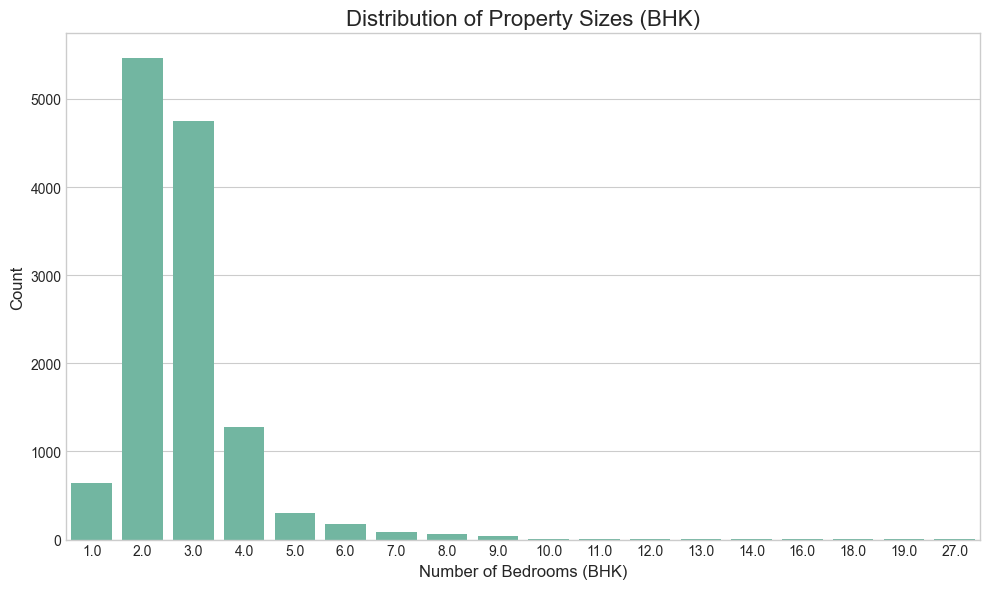

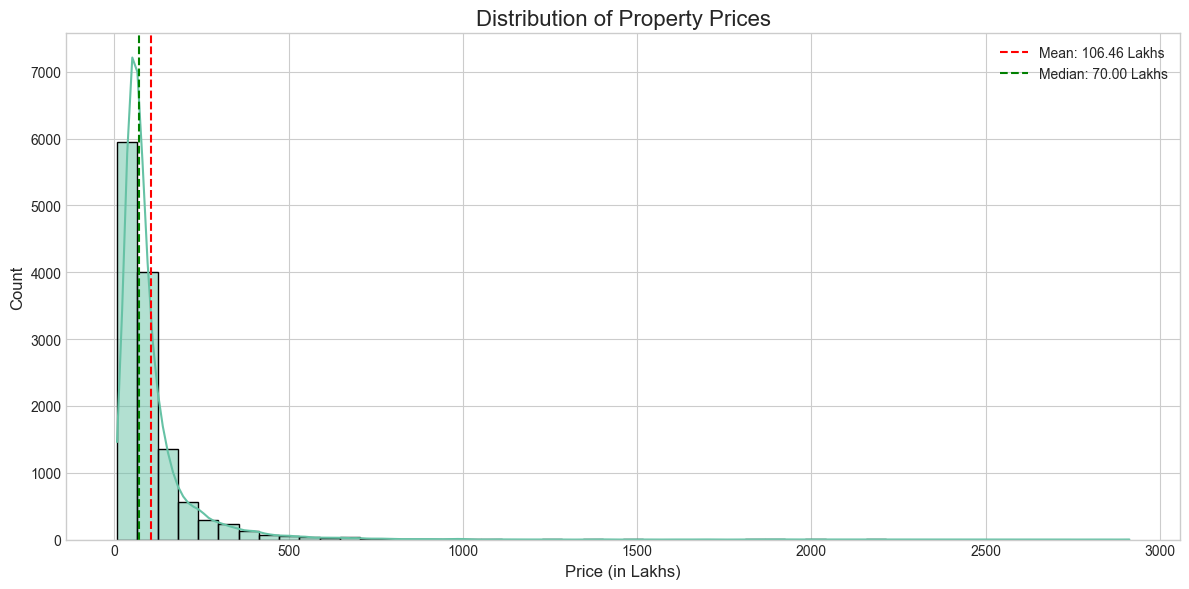

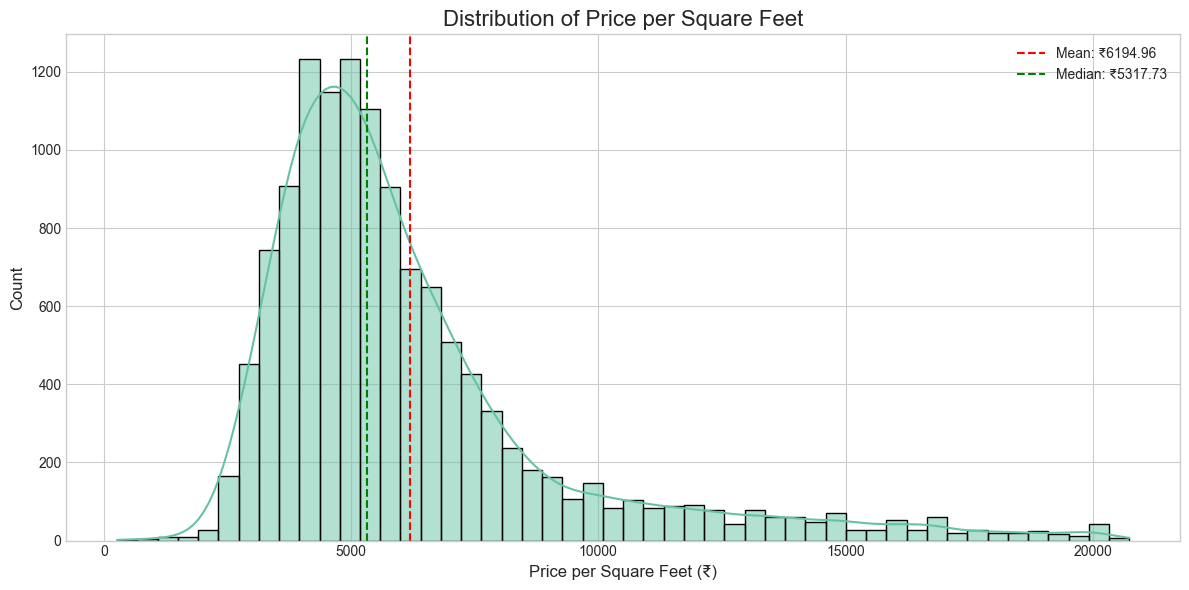

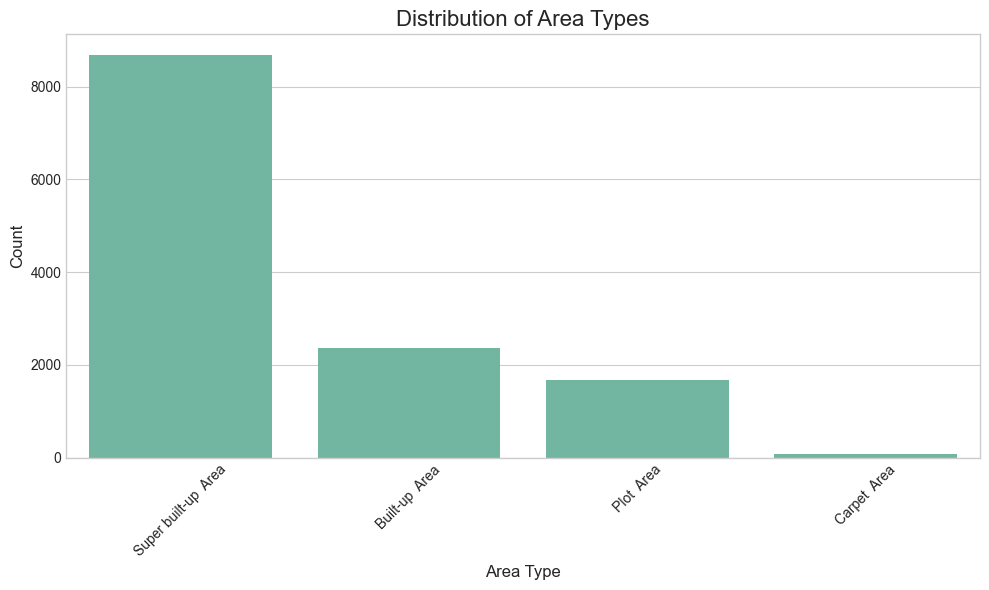

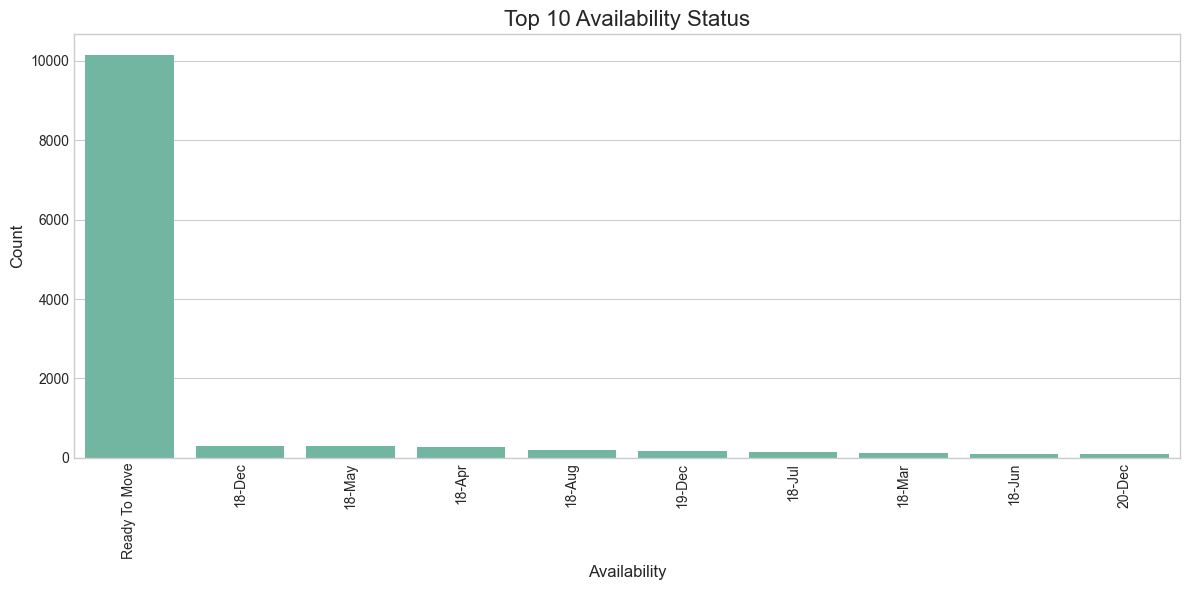

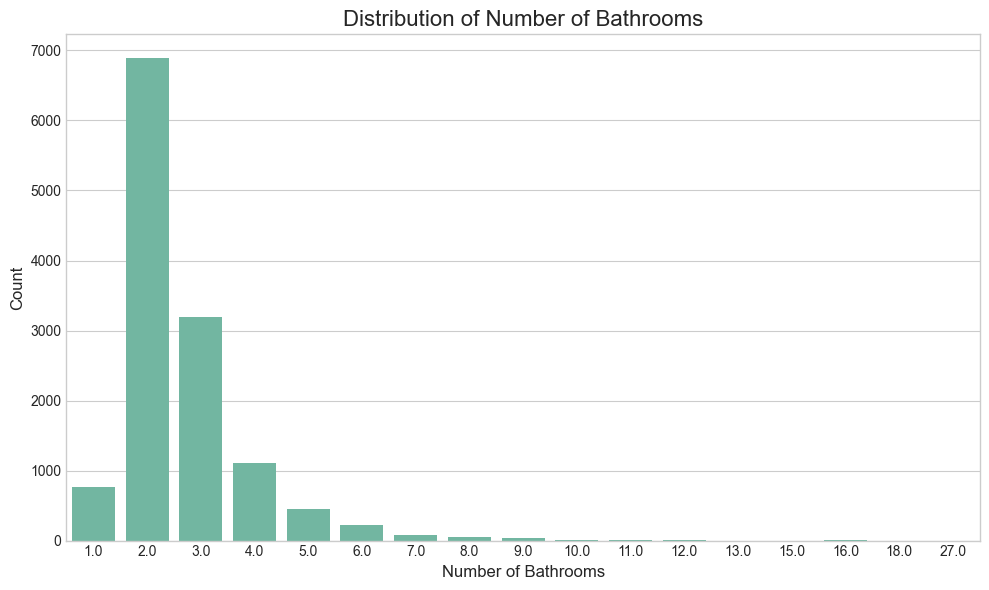

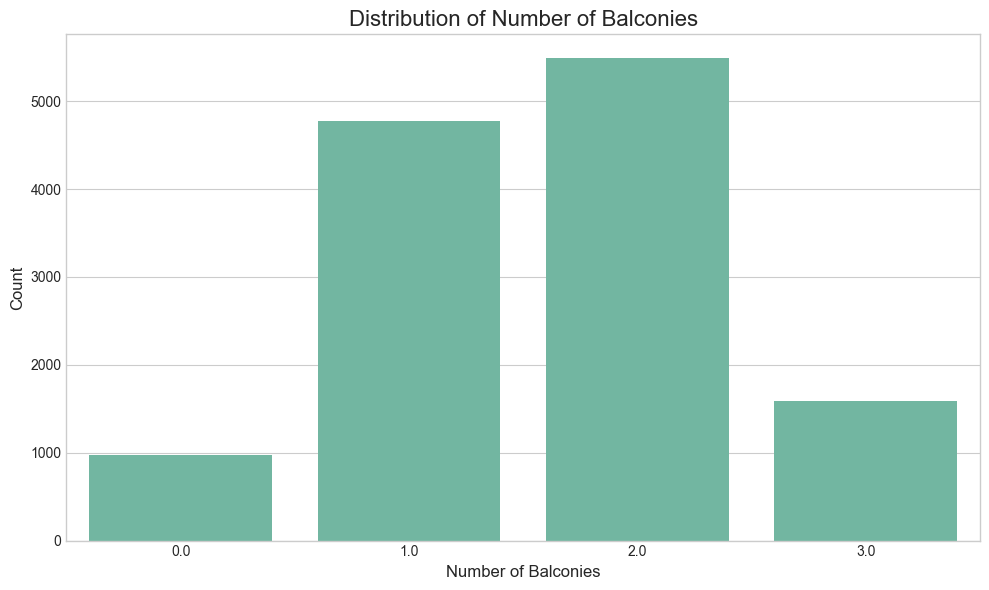

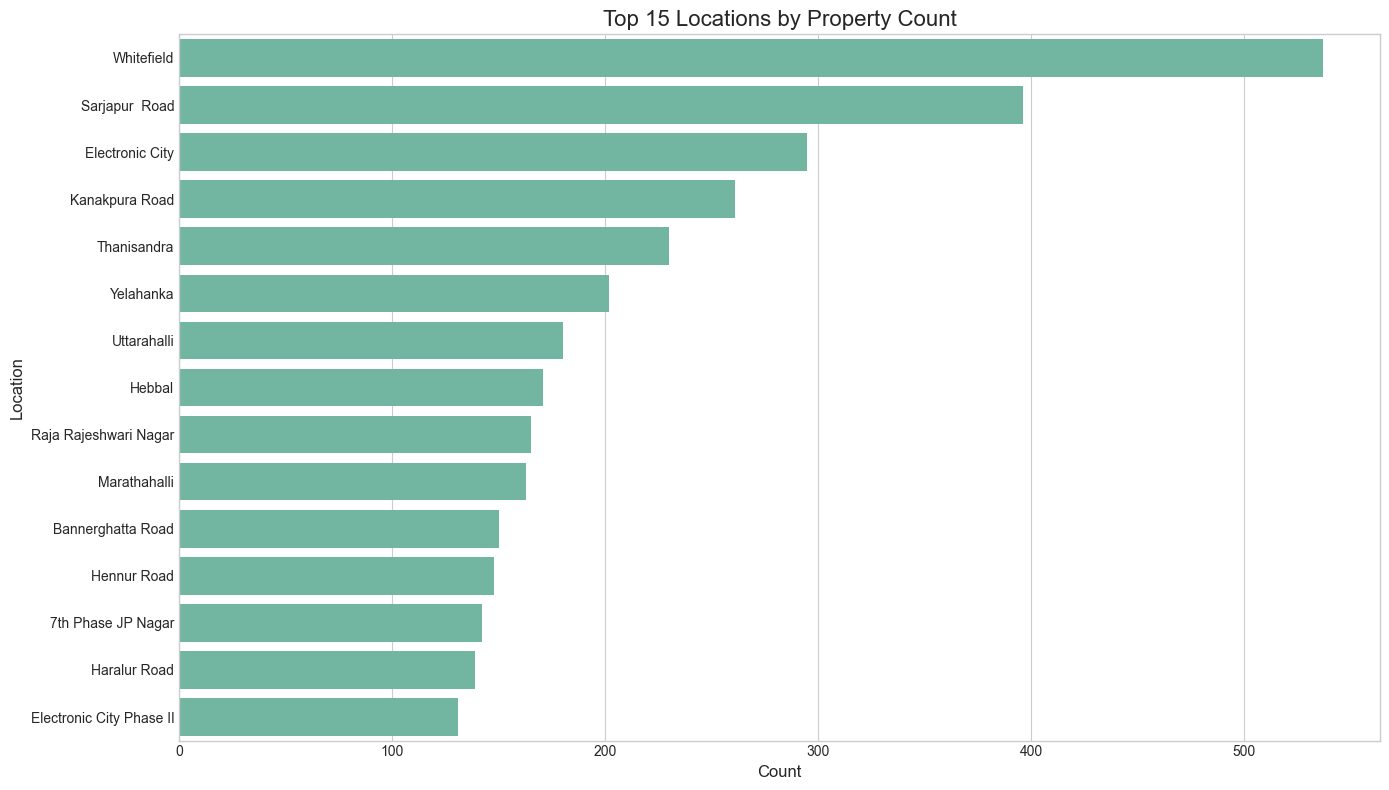

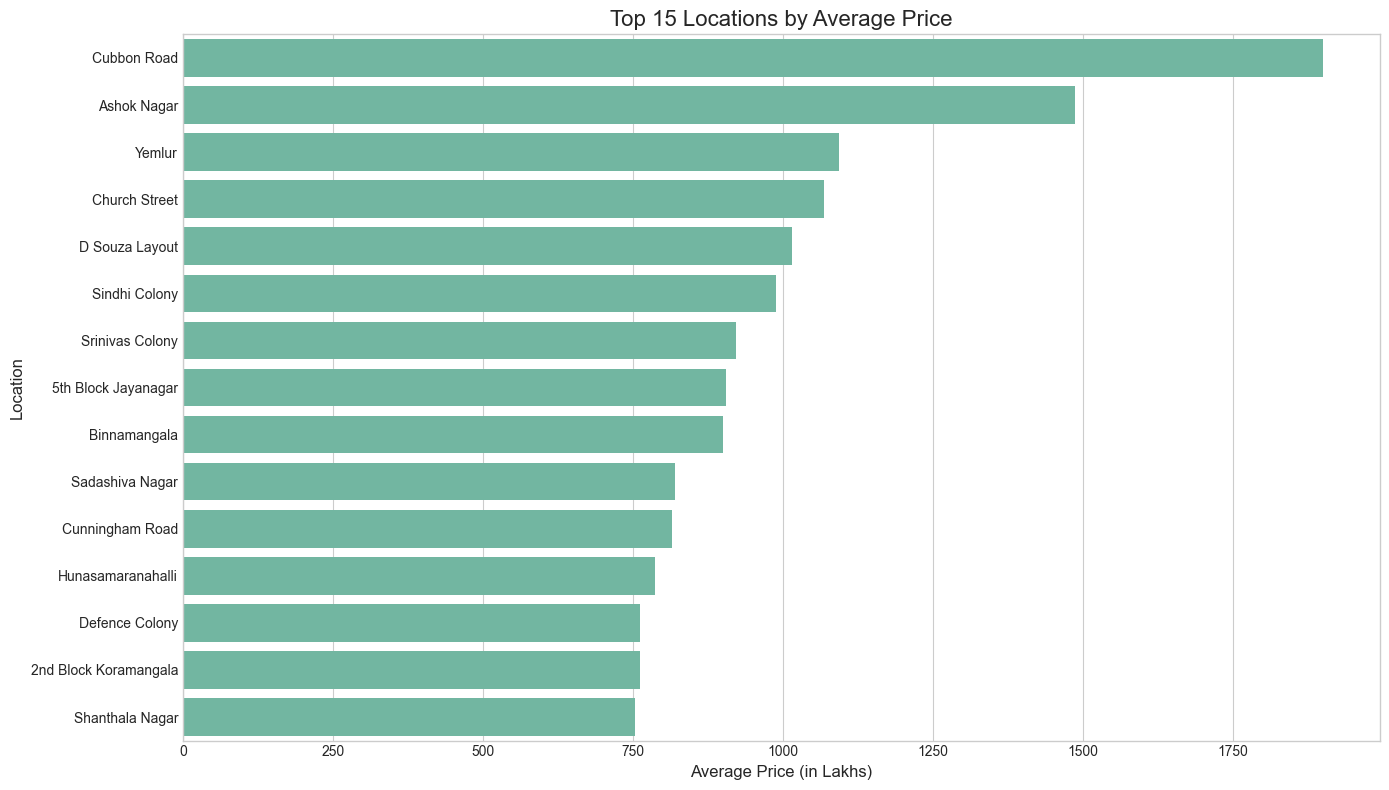

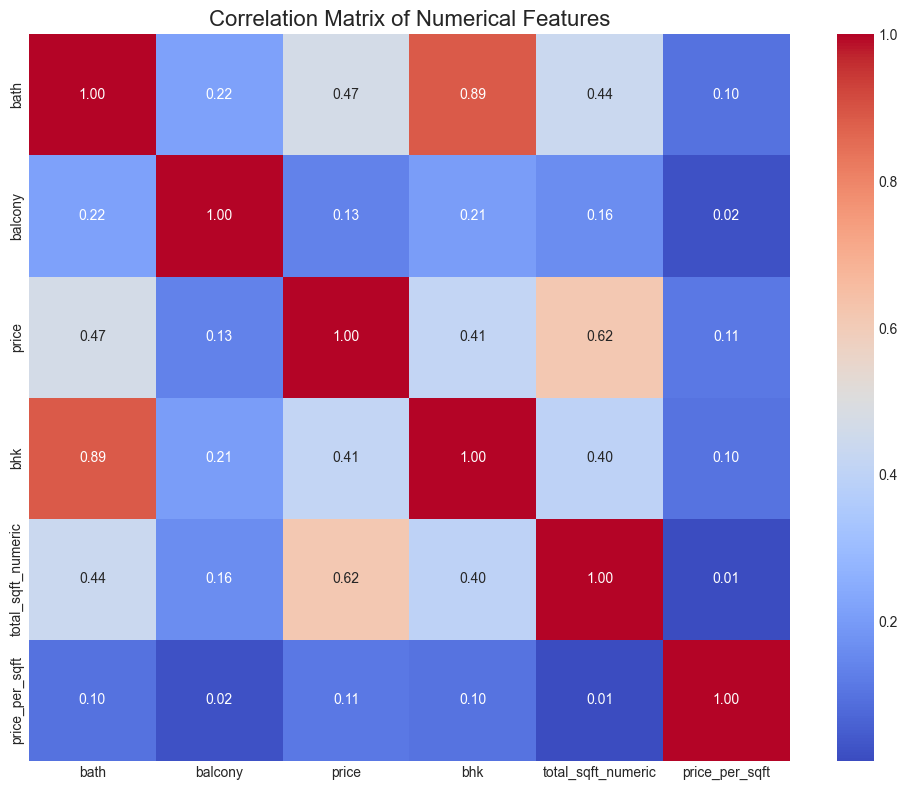

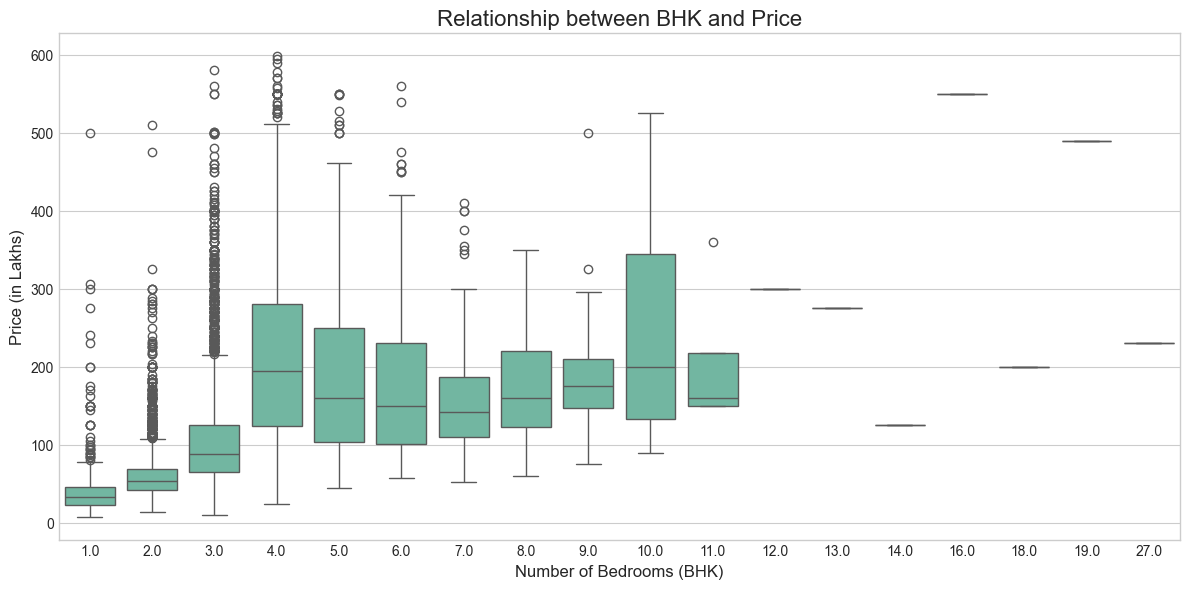

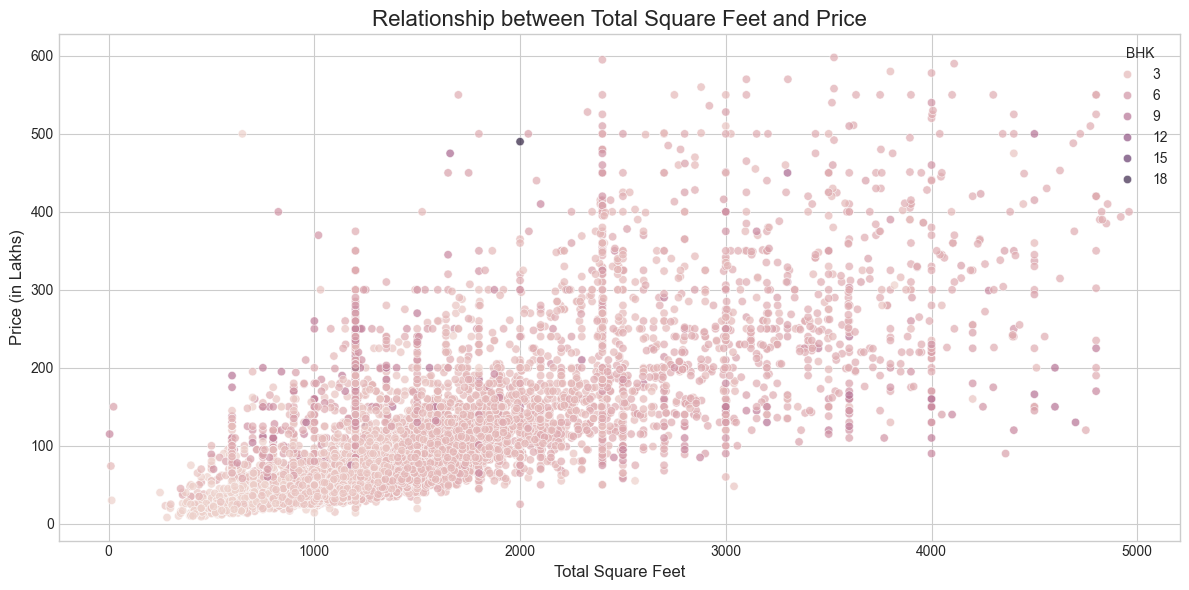

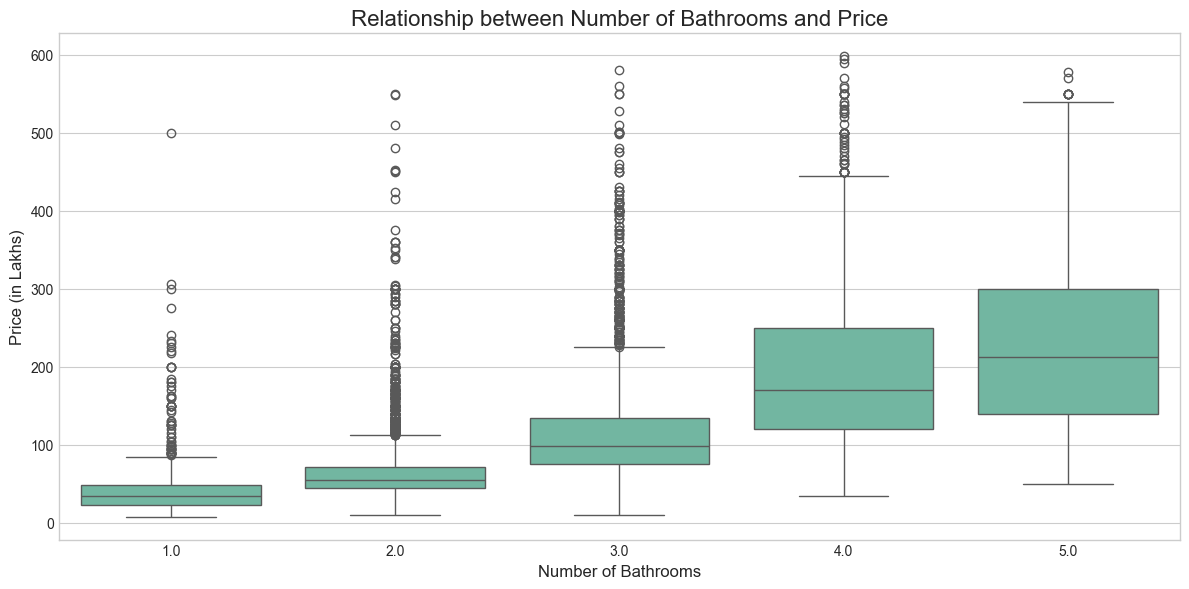

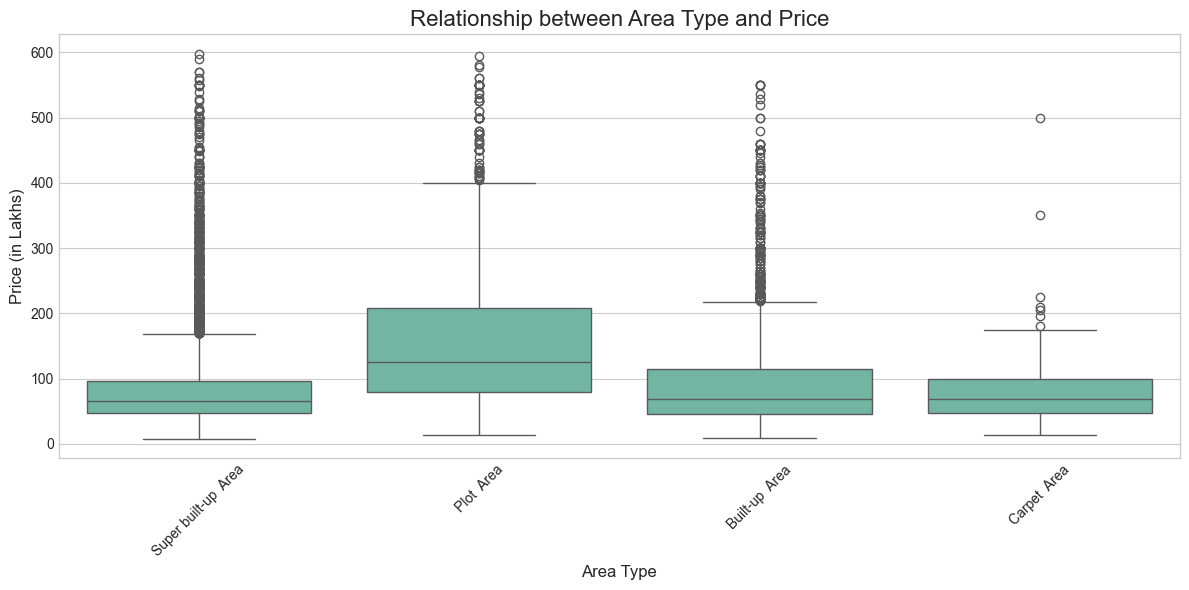

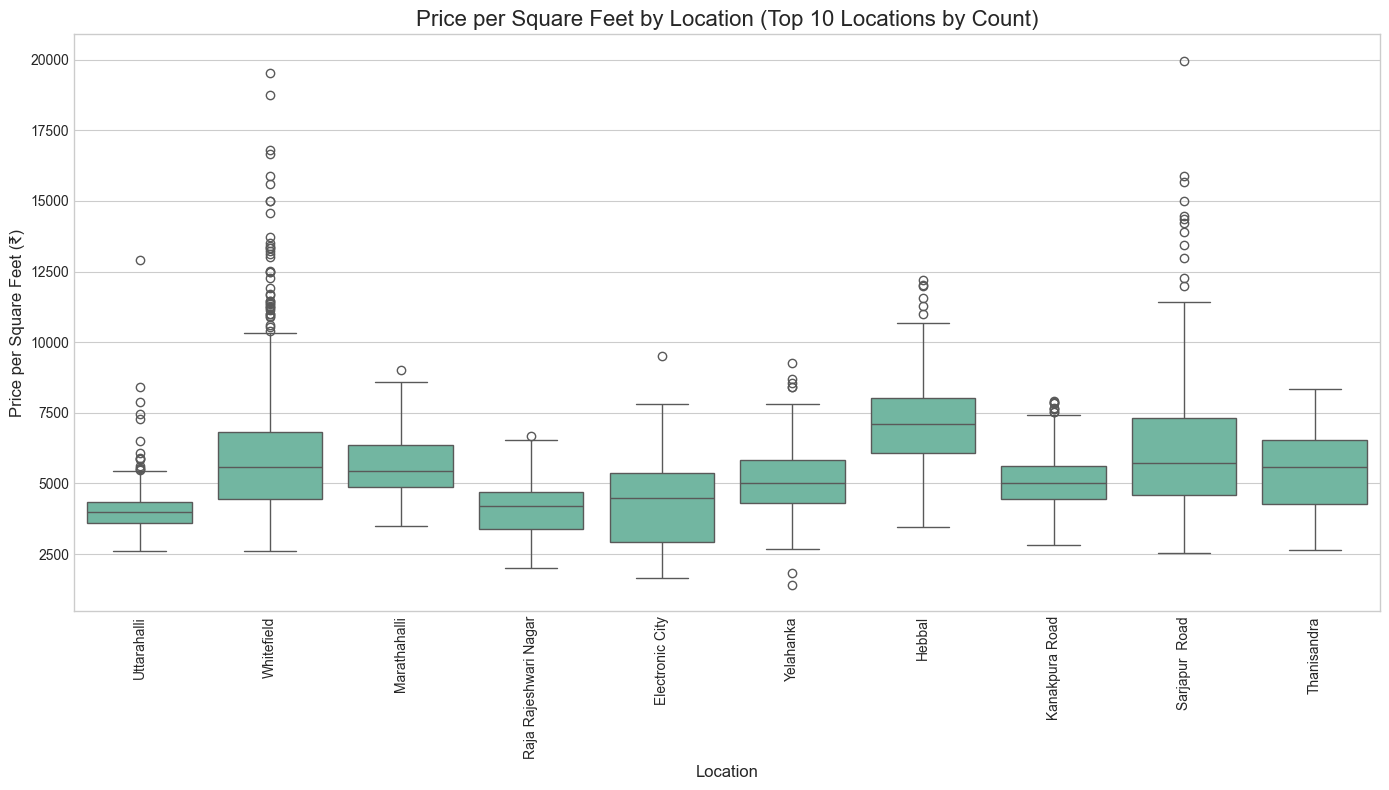

<Figure size 1400x800 with 0 Axes>

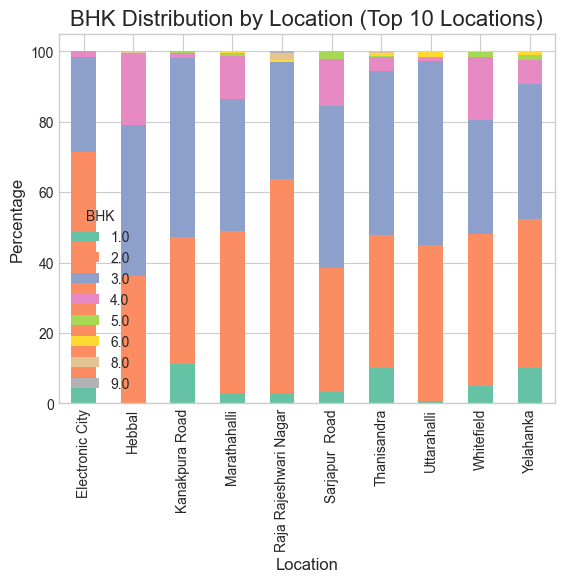

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Set the style for the plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

# Load the cleaned dataset
df = pd.read_csv('D:/AI foundations LunarTech/BangalureHousePrediction/Bengaluru_House_Data.csv')

# 1. Basic statistics and distributions
print("Dataset Shape:", df.shape)
print("\nBasic Statistics for Numerical Columns:")
print(df[['bath', 'balcony', 'price', 'bhk', 'total_sqft_numeric', 'price_per_sqft']].describe())

# 2. Distribution of property sizes (BHK)
plt.figure(figsize=(10, 6))
bhk_counts = df['bhk'].value_counts().sort_index()
sns.barplot(x=bhk_counts.index, y=bhk_counts.values)
plt.title('Distribution of Property Sizes (BHK)', fontsize=16)
plt.xlabel('Number of Bedrooms (BHK)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('D:/AI foundations LunarTech/BangalureHousePrediction/Visualization/bhk_distribution.png')
print("\nBHK Distribution:")
print(bhk_counts)

# 3. Distribution of property prices
plt.figure(figsize=(12, 6))
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Distribution of Property Prices', fontsize=16)
plt.xlabel('Price (in Lakhs)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.axvline(df['price'].mean(), color='red', linestyle='--', label=f'Mean: {df["price"].mean():.2f} Lakhs')
plt.axvline(df['price'].median(), color='green', linestyle='--', label=f'Median: {df["price"].median():.2f} Lakhs')
plt.legend()
plt.tight_layout()
plt.savefig('D:/AI foundations LunarTech/BangalureHousePrediction/Visualization/price_distribution.png')

# 4. Distribution of price per square feet
plt.figure(figsize=(12, 6))
# Filter out extreme values for better visualization
price_per_sqft_filtered = df[df['price_per_sqft'] < df['price_per_sqft'].quantile(0.99)]
sns.histplot(price_per_sqft_filtered['price_per_sqft'], bins=50, kde=True)
plt.title('Distribution of Price per Square Feet', fontsize=16)
plt.xlabel('Price per Square Feet (₹)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.axvline(price_per_sqft_filtered['price_per_sqft'].mean(), color='red', linestyle='--', 
            label=f'Mean: ₹{price_per_sqft_filtered["price_per_sqft"].mean():.2f}')
plt.axvline(price_per_sqft_filtered['price_per_sqft'].median(), color='green', linestyle='--', 
            label=f'Median: ₹{price_per_sqft_filtered["price_per_sqft"].median():.2f}')
plt.legend()
plt.tight_layout()
plt.savefig('D:/AI foundations LunarTech/BangalureHousePrediction/Visualization/price_per_sqft_distribution.png')

# 5. Distribution of area types
plt.figure(figsize=(10, 6))
area_type_counts = df['area_type'].value_counts()
sns.barplot(x=area_type_counts.index, y=area_type_counts.values)
plt.title('Distribution of Area Types', fontsize=16)
plt.xlabel('Area Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('D:/AI foundations LunarTech/BangalureHousePrediction/Visualization/area_type_distribution.png')
print("\nArea Type Distribution:")
print(area_type_counts)

# 6. Distribution of availability status
plt.figure(figsize=(12, 6))
availability_counts = df['availability'].value_counts().head(10)  # Top 10 for readability
sns.barplot(x=availability_counts.index, y=availability_counts.values)
plt.title('Top 10 Availability Status', fontsize=16)
plt.xlabel('Availability', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('D:/AI foundations LunarTech/BangalureHousePrediction/Visualization/availability_distribution.png')
print("\nTop 10 Availability Status:")
print(availability_counts)

# 7. Distribution of number of bathrooms
plt.figure(figsize=(10, 6))
bath_counts = df['bath'].value_counts().sort_index()
sns.barplot(x=bath_counts.index, y=bath_counts.values)
plt.title('Distribution of Number of Bathrooms', fontsize=16)
plt.xlabel('Number of Bathrooms', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('D:/AI foundations LunarTech/BangalureHousePrediction/Visualization/bathroom_distribution.png')
print("\nBathroom Distribution:")
print(bath_counts)

# 8. Distribution of number of balconies
plt.figure(figsize=(10, 6))
balcony_counts = df['balcony'].value_counts().sort_index()
sns.barplot(x=balcony_counts.index, y=balcony_counts.values)
plt.title('Distribution of Number of Balconies', fontsize=16)
plt.xlabel('Number of Balconies', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('D:/AI foundations LunarTech/BangalureHousePrediction/Visualization/balcony_distribution.png')
print("\nBalcony Distribution:")
print(balcony_counts)

# 9. Top 15 locations by property count
plt.figure(figsize=(14, 8))
location_counts = df['location'].value_counts().head(15)
sns.barplot(x=location_counts.values, y=location_counts.index)
plt.title('Top 15 Locations by Property Count', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Location', fontsize=12)
plt.tight_layout()
plt.savefig('D:/AI foundations LunarTech/BangalureHousePrediction/Visualization/top_locations_by_count.png')
print("\nTop 15 Locations by Property Count:")
print(location_counts)

# 10. Top 15 locations by average price
location_avg_price = df.groupby('location')['price'].mean().sort_values(ascending=False).head(15)
plt.figure(figsize=(14, 8))
sns.barplot(x=location_avg_price.values, y=location_avg_price.index)
plt.title('Top 15 Locations by Average Price', fontsize=16)
plt.xlabel('Average Price (in Lakhs)', fontsize=12)
plt.ylabel('Location', fontsize=12)
plt.tight_layout()
plt.savefig('D:/AI foundations LunarTech/BangalureHousePrediction/Visualization/top_locations_by_price.png')
print("\nTop 15 Locations by Average Price:")
print(location_avg_price)

# 11. Correlation between numerical features
plt.figure(figsize=(10, 8))
correlation_matrix = df[['bath', 'balcony', 'price', 'bhk', 'total_sqft_numeric', 'price_per_sqft']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.tight_layout()
plt.savefig('D:/AI foundations LunarTech/BangalureHousePrediction/Visualization/correlation_matrix.png')
print("\nCorrelation Matrix:")
print(correlation_matrix)

# 12. Relationship between BHK and Price
plt.figure(figsize=(12, 6))
sns.boxplot(x='bhk', y='price', data=df[df['price'] < df['price'].quantile(0.99)])
plt.title('Relationship between BHK and Price', fontsize=16)
plt.xlabel('Number of Bedrooms (BHK)', fontsize=12)
plt.ylabel('Price (in Lakhs)', fontsize=12)
plt.tight_layout()
plt.savefig('D:/AI foundations LunarTech/BangalureHousePrediction/Visualization/bhk_vs_price.png')

# 13. Relationship between Total Square Feet and Price
plt.figure(figsize=(12, 6))
# Filter out extreme values for better visualization
df_filtered = df[(df['total_sqft_numeric'] < df['total_sqft_numeric'].quantile(0.99)) & 
                 (df['price'] < df['price'].quantile(0.99))]
sns.scatterplot(x='total_sqft_numeric', y='price', hue='bhk', data=df_filtered, alpha=0.7)
plt.title('Relationship between Total Square Feet and Price', fontsize=16)
plt.xlabel('Total Square Feet', fontsize=12)
plt.ylabel('Price (in Lakhs)', fontsize=12)
plt.legend(title='BHK')
plt.tight_layout()
plt.savefig('D:/AI foundations LunarTech/BangalureHousePrediction/Visualization/sqft_vs_price.png')

# 14. Relationship between Number of Bathrooms and Price
plt.figure(figsize=(12, 6))
sns.boxplot(x='bath', y='price', data=df[(df['bath'] <= 5) & (df['price'] < df['price'].quantile(0.99))])
plt.title('Relationship between Number of Bathrooms and Price', fontsize=16)
plt.xlabel('Number of Bathrooms', fontsize=12)
plt.ylabel('Price (in Lakhs)', fontsize=12)
plt.tight_layout()
plt.savefig('D:/AI foundations LunarTech/BangalureHousePrediction/Visualization/bath_vs_price.png')

# 15. Relationship between Area Type and Price
plt.figure(figsize=(12, 6))
sns.boxplot(x='area_type', y='price', data=df[df['price'] < df['price'].quantile(0.99)])
plt.title('Relationship between Area Type and Price', fontsize=16)
plt.xlabel('Area Type', fontsize=12)
plt.ylabel('Price (in Lakhs)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('D:/AI foundations LunarTech/BangalureHousePrediction/Visualization/area_type_vs_price.png')

# 16. Price Trends by Availability
# Extract year from availability if it's a date
def extract_year(x):
    if isinstance(x, str) and len(x) > 4 and x[-4:].isdigit():
        return int(x[-4:])
    return None

df['year'] = df['availability'].apply(extract_year)
yearly_price = df[df['year'].notna()].groupby('year')['price'].mean().reset_index()

if not yearly_price.empty:
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='year', y='price', data=yearly_price, marker='o')
    plt.title('Average Price Trend by Year of Availability', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Average Price (in Lakhs)', fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('D:/AI foundations LunarTech/BangalureHousePrediction/Visualization/price_trend_by_year.png')
    print("\nAverage Price Trend by Year:")
    print(yearly_price)

# 17. Price per Square Feet by Location (Top 10 locations by count)
top_locations = df['location'].value_counts().head(10).index
plt.figure(figsize=(14, 8))
sns.boxplot(x='location', y='price_per_sqft', 
            data=df[(df['location'].isin(top_locations)) & 
                    (df['price_per_sqft'] < df['price_per_sqft'].quantile(0.99))])
plt.title('Price per Square Feet by Location (Top 10 Locations by Count)', fontsize=16)
plt.xlabel('Location', fontsize=12)
plt.ylabel('Price per Square Feet (₹)', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()

# 18. BHK Distribution by Location (Top 10 locations)
bhk_by_location = pd.crosstab(df[df['location'].isin(top_locations)]['location'], 
                              df[df['location'].isin(top_locations)]['bhk'])
bhk_by_location_percentage = bhk_by_location.div(bhk_by_location.sum(axis=1), axis=0) * 100

plt.figure(figsize=(14, 8))
bhk_by_location_percentage.plot(kind='bar', stacked=True)
plt.title('BHK Distribution by Location (Top 10 Locations)', fontsize=16)
plt.xlabel('Location', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.legend(title='BHK')
plt.xticks(rotation=90)
plt.savefig('D:/AI foundations LunarTech/BangalureHousePrediction/Visualization/distribution.png')
print("\nBHK Distribution by Location (Top 10):")
print(bhk_by_location)

# Save summary statistics to a file
with open('D:/AI foundations LunarTech/BangalureHousePrediction/Visualization/exploratory_analysis_summary.txt', 'w') as f:
    f.write("Bengaluru House Data - Exploratory Analysis Summary\n")
    f.write("=" * 50 + "\n\n")
    
    f.write("1. Dataset Overview\n")
    f.write("-" * 20 + "\n")
    f.write(f"Total number of properties: {df.shape[0]}\n")
    f.write(f"Number of features: {df.shape[1]}\n\n")
    
    #f.write("2. Price Statistics (in Lakhs)\n")
    #f.write("-" * 20 + "\n")
    # f.write(f"Median price: ₹{df['price'].median():.2f} Lakhs\n")
    # f.write(f"Minimum price: ₹{df['price'].min():.2f} Lakhs\n")
    # f.write(f"Maximum price: ₹{df['price'].max():.2f} Lakhs\n")
    # f.write(f"Standard deviation: ₹{df['price'].std():.2f} Lakhs\n\n")
    
    f.write("3. Property Size Distribution\n")
    f.write("-" * 20 + "\n")
    for bhk, count in bhk_counts.items():
        f.write(f"{int(bhk)} BHK: {count} properties ({count/len(df)*100:.2f}%)\n")
    f.write("\n")
    
    f.write("4. Area Type Distribution\n")
    f.write("-" * 20 + "\n")
    for area_type, count in area_type_counts.items():
        f.write(f"{area_type}: {count} properties ({count/len(df)*100:.2f}%)\n")
    f.write("\n")
    
    f.write("5. Top 10 Locations by Property Count\n")
    f.write("-" * 20 + "\n")
    for location, count in location_counts.items():
        f.write(f"{location}: {count} properties\n")
    f.write("\n")
    
    # f.write("6. Top 10 Locations by Average Price\n")
    # f.write("-" * 20 + "\n")
    # for location, avg_price in location_avg_price.head(10).items():
        # f.write(f"{location}: ₹{avg_price:.2f} Lakhs\n")
    # f.write("\n")
    
    f.write("7. Correlation Analysis\n")
    f.write("-" * 20 + "\n")
    f.write("Correlation between Total Square Feet and Price: ")
    f.write(f"{correlation_matrix.loc['total_sqft_numeric', 'price']:.4f}\n")
    f.write("Correlation between BHK and Price: ")
    f.write(f"{correlation_matrix.loc['bhk', 'price']:.4f}\n")
    f.write("Correlation between Number of Bathrooms and Price: ")
    f.write(f"{correlation_matrix.loc['bath', 'price']:.4f}\n")
    f.write("Correlation between Number of Balconies and Price: ")
    f.write(f"{correlation_matrix.loc['balcony', 'price']:.4f}\n\n")
    
    f.write("8. Price per Square Feet Analysis\n")
    f.write("-" * 20 + "\n")
    f.write(f"Average price per square feet: ₹{df['price_per_sqft'].mean():.2f}\n")
    f.write(f"Median price per square feet: ₹{df['price_per_sqft'].median():.2f}\n")
    f.write(f"Minimum price per square feet: ₹{df['price_per_sqft'].min():.2f}\n")
    f.write(f"Maximum price per square feet: ₹{df['price_per_sqft'].max():.2f}\n")
    f.write(f"Standard deviation: ₹{df['price_per_sqft'].std():.2f}\n")

print("\nExploratory data analysis completed. Results saved to D:/AI foundations LunarTech/BangalureHousePrediction/Visualization/exploratory_analysis_summary.txt")
print("Visualizations saved to D:/AI foundations LunarTech/BangalureHousePrediction/Visualization directory")